### CART Model

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
stockx_data = pd.read_excel("./StockX-Data-Contest-2019.xlsx",sheet_name="Raw Data")
color = pd.read_excel("./supplemental_data_colorway.xlsx",sheet_name="Sheet1")

In [2]:
# --- Data Cleaning ---
# calculate price premium: (sale price - retail price)/retail price
stockx_data["Price_Percentage_change"] = (stockx_data['Sale Price'] - stockx_data['Retail Price'])/stockx_data['Retail Price']

# calculate days since release: order data - release date
stockx_data["Days_Since_Release"] = (pd.to_datetime(stockx_data['Order Date']) - pd.to_datetime(stockx_data['Release Date']))/np.timedelta64('1','D')

# --- style variables ---
# style: v2
stockx_data["yeezy"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Yeezy' in x.split("-") else 0)
# style: airjordan
stockx_data["airjordan"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Jordan' in x.split("-") else 0)
# style: airforce
stockx_data["airforce"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Force' in x.split("-") else 0)
# style: airmax90
stockx_data["airmax90"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if '90' in x.split("-") else 0)
# style: airmax97
stockx_data["airmax97"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if '97' in x.split("-") else 0)
# style: presto
stockx_data["presto"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Presto' in x.split("-") else 0)
# style: vapormax
stockx_data["vapormax"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'VaporMax' in x.split("-") else 0)
# style: blazer
stockx_data["blazer"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Blazer' in x.split("-") else 0)
# style: zoom
stockx_data["zoom"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'Zoom' in x.split("-") else 0)
# style: zoom
stockx_data["react"] = stockx_data['Sneaker Name'].apply(lambda x : 1 if 'React' in x.split("-") else 0)

# --- state variables ---
# creating the california variable
stockx_data["California"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'California' in x else 0)
# creating the new_york variable
stockx_data["New York"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'New York' in x else 0)
# creating the oregon variable
stockx_data["Oregon"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'Oregon' in x else 0)
# creating the florida variable
stockx_data["Florida"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'Florida' in x else 0)
# creating the texas variable
stockx_data["Texas"] = stockx_data["Buyer Region"].apply(lambda x : 1 if 'Texas' in x else 0)
# creating the other_state variable
above5pct_states = ["California", "New York", "Oregon", "Florida", "Texas"]
stockx_data["Other States"] = pd.Series(list(map(int,~stockx_data["Buyer Region"].isin(above5pct_states))))


In [3]:
stockx_data = stockx_data.merge(color, left_on = 'Sneaker Name', right_on = 'Style', how = 'left')
stockx_data = stockx_data.drop(columns = ['Order Date', 'Brand','Sneaker Name', 'Release Date', 'Buyer Region',
                                         'Website', 'Product Line', 'Style'])
stockx_data = stockx_data.fillna(0)

In [4]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree


# Load the data
y = stockx_data["Price_Percentage_change"]
X = sm.add_constant(stockx_data.drop(["Sale Price",'Price_Percentage_change', "Other States", "New York", "Texas"], axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=808)

# Finding the best ccp_alpha value
ccp_alphas = np.linspace(0, 0.01, 20) 
mse_scores = []

for ccp_alpha in ccp_alphas:
    model = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    mse_scores.append(np.mean((model.predict(X_test) - y_test)**2))

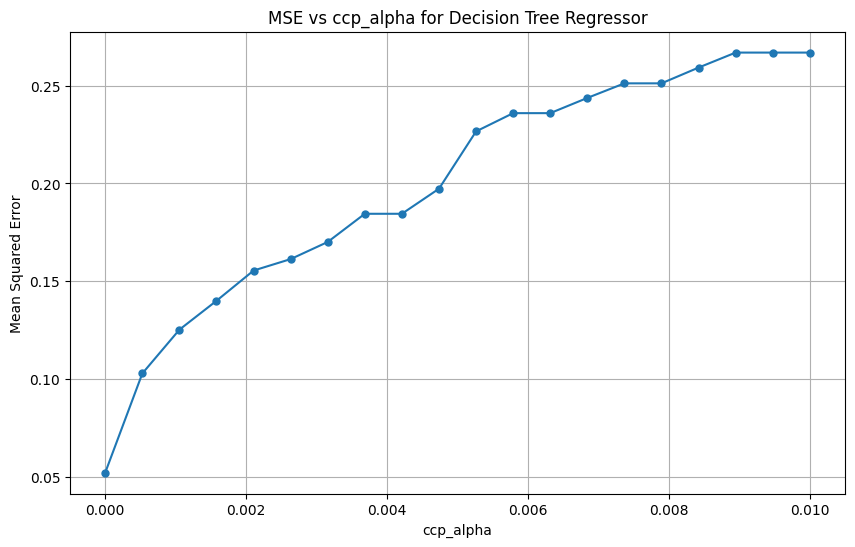

The best ccp_alpha value is: 0.0


In [5]:
# Plotting the MSE scores against ccp_alpha values
plt.figure(figsize=(10,6))
plt.plot(ccp_alphas, mse_scores, marker='o', linestyle='-', markersize=5)
plt.title('MSE vs ccp_alpha for Decision Tree Regressor')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

# Find the ccp_alpha value with the lowest MSE
best_ccp_alpha = ccp_alphas[np.argmin(mse_scores)]
print(f"The best ccp_alpha value is: {best_ccp_alpha}")


In [6]:
# Train a CART model with the best ccp_alpha value
cart_model = DecisionTreeRegressor(ccp_alpha=best_ccp_alpha)
cart_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions
y_pred = cart_model.predict(X_test)

# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"OSR² score: {r2}")

Mean Absolute Error (MAE): 0.08799256435161693
Mean Squared Error (MSE): 0.05049973325165131
Root Mean Squared Error (RMSE): 0.22472145703437246
OSR² score: 0.9777333060035357


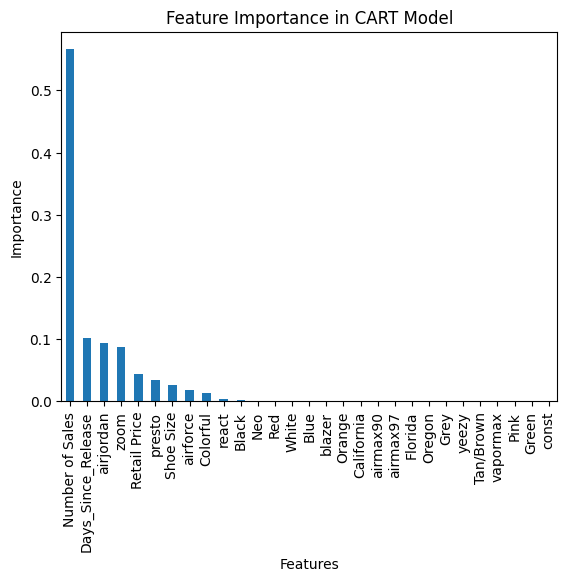

In [9]:
# Feature importance
import pandas as pd

feature_importances = pd.Series(cart_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

# Plotting the feature importances
feature_importances.plot(kind='bar')
plt.title('Feature Importance in CART Model')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

### CART Model with PCA

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


# Standardize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_pca = pca.fit_transform(X_scaled)

X_pca_df = pd.DataFrame(data=X_pca)

In [11]:
#CART model with PCA 

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.33, random_state=808)

cart_model = DecisionTreeRegressor(random_state=808)
cart_model.fit(X_train_pca, y_train)

cart_predictions_pca = cart_model.predict(X_test_pca)
cart_mse_pca = mean_squared_error(y_test, cart_predictions_pca)
rmse_pca = np.sqrt(mse)
r_squared_pca = r2_score(y_test, cart_predictions_pca)

print(f"CART Model MSE with PCA: {cart_mse_pca}")
print(f"Root Mean Squared Error (RMSE): {rmse_pca}")
print(f"R-squared: {r_squared_pca}")

CART Model MSE with PCA: 0.07003768011448201
Root Mean Squared Error (RMSE): 0.22472145703437246
R-squared: 0.9691184984372085
